In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Fetch data
url = "http://127.0.0.1:8000/api/v1/data/?table_name=precios_materiales&limit=1000"
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print(f"✓ Successfully fetched {len(data['data'])} records")
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    raise
# Convert to Data Frame
df = pd.DataFrame(data['data'])

#Convert date to date of Dataframe
df['date'] = pd.to_datetime(df['date'])




✓ Successfully fetched 190 records


En este ejemplo analizare la serie de tiempo del precio de la varilla del distribuidor


0      20038.525
1      19969.630
2      20406.947
3      20571.158
4      21856.105
         ...    
185    13465.895
186    13817.432
187    13729.643
188    13709.789
189    13748.505
Name: varilla_distribuidor, Length: 190, dtype: float64


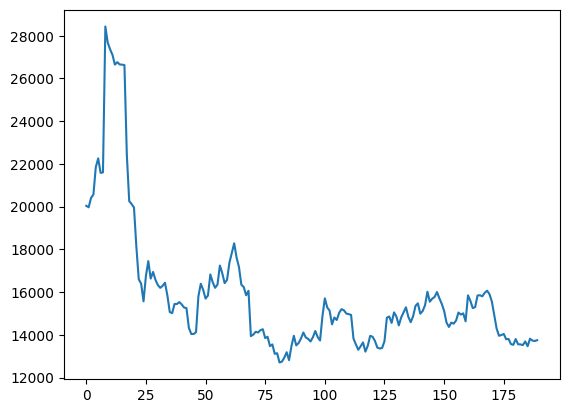

In [8]:
varilla_distribuidor = df['varilla_distribuidor']

plt.plot(varilla_distribuidor)
print(varilla_distribuidor)



Analisis visual del precio de la varilla, hay un pico fuerte en el precio de los primeros 20 periodos, en donde sube hasta ~28,000 analizando la informacion esto es de Enero 2022 a aprox Marzo 2022
Luego hay una caida pronunciada hasta el periodo 25, desde marzo 2022 hasta Finales del 2022 en donde el precio esta en ~13,000

Despues de ese periodo oscila entre 13,000 y 16,000

Tendencia
Puedo ver una tendencia descendente, y luego la serie se estabiliza

Estacionalidad
No observo visualmente una estacionalidad clara, no hay repeticiones regulares en los patrones

Volatilidad
Existe una volatilidad alta al inicio, pero despues de mantienen dentro de un rango.

Paso 1: Verificar estacionariedad

In [ ]:
from statsmodels.tsa.stattools import adfuller
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

result = adfuller(varilla_distribuidor)
print(f'p-value: {result[1]}')


p-value: 0.0002728249129244322


Como el p-value es menor a 0.05 la serie es estacionaria y puedo utilizar AR o MA 

Esto de interpreta que al hacer este analisis estadistico muestra la serie estable en el tiempo, no presenta tendencias aleatorias, y sus variaciones son predecibles dentro de un rango constante

Paso 2: Revisar ACF y PACF
Esto nos dira que modelo conviene

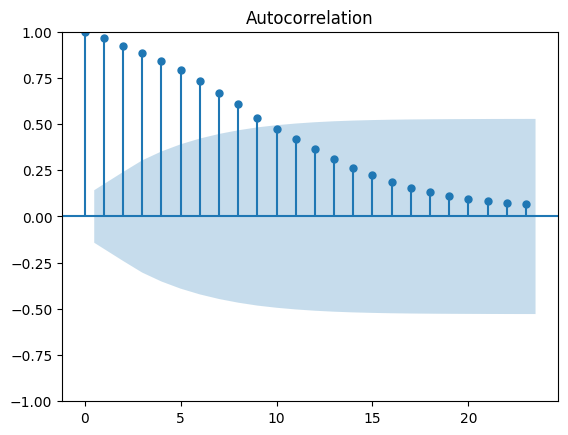

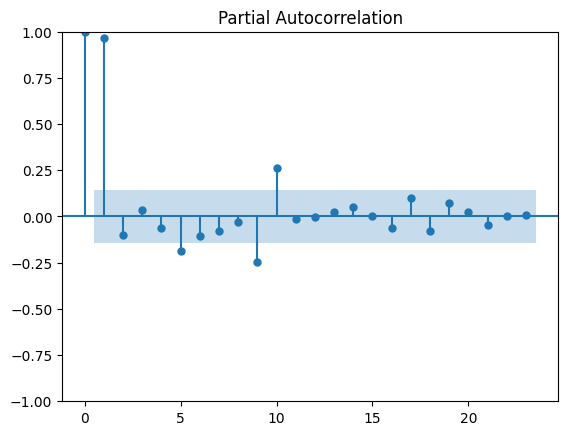

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(varilla_distribuidor)
plot_pacf(varilla_distribuidor)
plt.show()

In [ ]:
Al analizar ACF, se ve que decae lentamente, eso quiere decir que hay una tendencia, y se sugiere AR


En PACF veo un pico en el lag 1, y ahi corte la serie seguido lo de ahi oscila en la banda de confianza
Lo que se sugiere un AR(1)

In [18]:
from statsmodels.tsa.arima.model import ARIMA

#Autoregresivo orden 1
modelo = ARIMA(varilla_distribuidor, order=(1, 0,0))
resultado = modelo.fit()

print(resultado.summary())


#Autoregresivo orden 1
modelo_ma = ARIMA(varilla_distribuidor, order=(0, 0,1))
resultado_ma = modelo.fit()

print(resultado_ma.summary())


                                SARIMAX Results                                 
Dep. Variable:     varilla_distribuidor   No. Observations:                  190
Model:                   ARIMA(1, 0, 0)   Log Likelihood               -1532.655
Date:                  Mon, 20 Oct 2025   AIC                           3071.310
Time:                          11:56:20   BIC                           3081.051
Sample:                               0   HQIC                          3075.256
                                  - 190                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.586e+04   1993.360      7.957      0.000     1.2e+04    1.98e+04
ar.L1          0.9701      0.013     75.814      0.000       0.945       0.995
sigma2      5.831e+05   1.47e+04    